# Análisis del impacto de las Incidencias sobre los Ingresos

Este notebook analiza la relación estadística entre las incidencias operacionales y los ingresos de ventas.

**Objetivos:**
- Determinar si existe correlación entre número de incidencias e ingresos por día.
- Determinar si existe diferencia estadística en ingresos en días CON vs SIN incidencias.
- Desglosar las Incidencias por tipo y por grado de severidad y ver si se encuentran diferencias entre las categorías.
- Cuantificar, si es posible, el efecto económico de las incidencias.

## 1. Importar Librerías y Cargar Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [5]:
# Cargar datos
ventas = pd.read_csv('../data/processed/ventas400_proc2.csv')
incidencias = pd.read_csv('../data/processed/incidencias_proc2.csv')

# Convertir fechas
ventas['Fecha'] = pd.to_datetime(ventas['Fecha'])
incidencias['Fecha'] = pd.to_datetime(incidencias['Fecha'])

print("✓ Datos cargados")
print(f"Ventas: {len(ventas):,} registros")
print(f"Incidencias: {len(incidencias):,} registros")

✓ Datos cargados
Ventas: 7,273 registros
Incidencias: 54 registros


## 2. Preparación: Agregación por Día

In [6]:
ventas_diarias = ventas.groupby('Fecha').agg({
    'Suma de IngresosFila': 'sum',
    'TicketID': pd.Series.nunique # funcion de agregacion para contar tickets unicos
}).rename(columns={
    'Suma de IngresosFila': 'Ingresos',
    'TicketID': 'Tickets'
}).reset_index()


In [7]:
ventas_diarias.head()

,Fecha,Ingresos,Tickets
0,2024-01-01,639.40,34
1,2024-01-02,1116.47,50
2,2024-01-03,761.36,37
3,2024-01-04,809.75,42
4,2024-01-05,942.39,44


In [8]:

# Agregar incidencias por día
incidencias_diarias = incidencias.groupby('Fecha').agg({
    'IncidenciaID': 'count',
    'Suma de DuracionMin': 'sum'
}).rename(columns={'IncidenciaID': 'NumIncidencias'}).reset_index()


In [9]:
incidencias_diarias.head()

,Fecha,NumIncidencias,Suma de DuracionMin
0,2024-01-03,1,148
1,2024-01-05,1,106
2,2024-01-06,1,82
3,2024-01-07,1,94
4,2024-01-09,1,96


In [ ]:

# Combinar ambas tablas
df_diario = ventas_diarias.merge(incidencias_diarias, on='Fecha', how='left')
df_diario['NumIncidencias'] = df_diario['NumIncidencias'].fillna(0)
df_diario['Suma de DuracionMin'] = df_diario['Suma de DuracionMin'].fillna(0)
df_diario['TieneIncidencia'] = (df_diario['NumIncidencias'] > 0).astype(int)

print(f"Total días analizados: {len(df_diario)}")
print(f"Días con incidencias: {df_diario['TieneIncidencia'].sum()}")
print(f"Días sin incidencias: {(1-df_diario['TieneIncidencia']).sum()}")


Total días analizados: 91
Días con incidencias: 54
Días sin incidencias: 37


,Fecha,Ingresos,Tickets,NumIncidencias,Suma de DuracionMin,TieneIncidencia
0,2024-01-01,639.40,34,0.0,0.0,0
1,2024-01-02,1116.47,50,0.0,0.0,0
2,2024-01-03,761.36,37,1.0,148.0,1
3,2024-01-04,809.75,42,0.0,0.0,0
4,2024-01-05,942.39,44,1.0,106.0,1


In [ ]:
df_diario.head()

## 3. Análisis de Correlación entre Ingresos e Incidencias

### 3.1 Visualización: Scatter Plot con Regresión

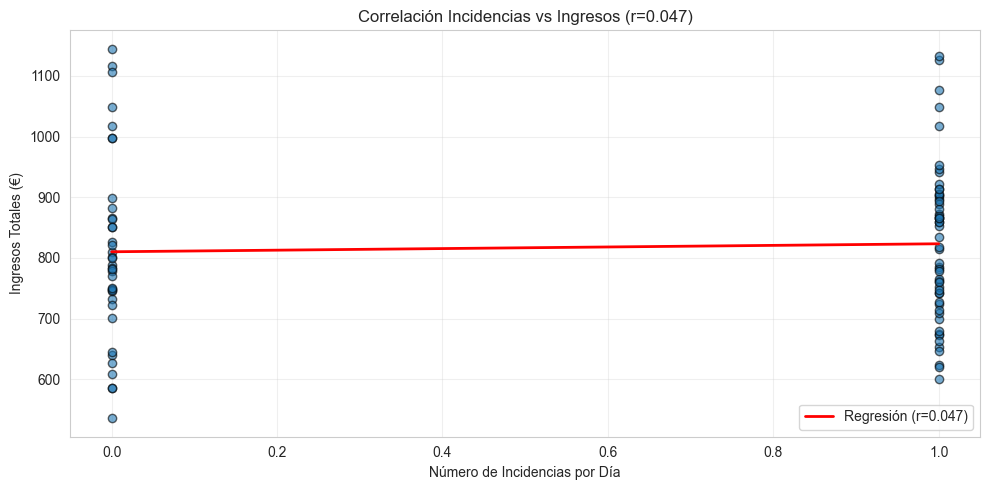

<Figure size 1200x600 with 0 Axes>

In [114]:

from scipy.stats import linregress

x = df_diario['NumIncidencias']
y = df_diario['Ingresos']
mask = x.notnull() & y.notnull()

slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])

plt.figure(figsize=(10,5))
# puntos (añadir pequeño jitter horizontal para visualizar solapamientos)
plt.scatter(x, y, alpha=0.6, edgecolor='k')
# recta de regresión
xx = np.linspace(x.min(), x.max(), 100)
plt.plot(xx, intercept + slope*xx, color='red', linewidth=2, label=f'Regresión (r={r_value:.3f})')

plt.title(f'Correlación Incidencias vs Ingresos (r={r_value:.3f})')
plt.xlabel('Número de Incidencias por Día')
plt.ylabel('Ingresos Totales (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('../images/correlacion_incidencias_ingresos.png', dpi=300)
# ...existing code...

Se observa que la variable Incidencia es binaria, tomando sólo 0 y 1 como valores. No se puede usar el coeficiente de correlación Pearson.

Utilizaremos la prueba Point - biserial correlation, que es una variable de la prueba Pearson que se usa cuando una variable es continua y la otra binaria. También usaremos como referencia el test Spearman.

In [30]:
from scipy.stats import pointbiserialr

corr_pbis, pvalue_pbis = pointbiserialr(df_diario['NumIncidencias'], df_diario['Ingresos'])
corr_sper, pvalue_sper = spearmanr(df_diario['NumIncidencias'], df_diario['Ingresos'])

print("=" * 60)
print("ANÁLISIS DE CORRELACIÓN: Incidencias vs Ingresos")
print("=" * 60)
print(f"\nPoint Biserial Correlation:   {corr_pbis:.4f} (p-value: {pvalue_pbis:.4e})")
print(f"Spearman Correlation:  {corr_sper:.4f} (p-value: {pvalue_sper:.4e})")

if pvalue_pbis < 0.05:
    significancia = "estadísticamente significativa (p < 0.05)"
else:
    significancia = "NO significativa (p >= 0.05)"
    
print(f"\n📊 Conclusión: La correlación es {significancia}")

#if abs(pearson_corr) < 0.3:
    #fuerza = "débil"
#elif abs(pearson_corr) < 0.7:
    #fuerza = "moderada"
#else:
    #fuerza = "fuerte"
    
#direccion = "negativa" if pearson_corr < 0 else "positiva"
#print(f"   Fuerza: {fuerza}, Dirección: {direccion}")

ANÁLISIS DE CORRELACIÓN: Incidencias vs Ingresos

Point Biserial Correlation:   0.0475 (p-value: 6.5484e-01)
Spearman Correlation:  0.0788 (p-value: 4.5791e-01)

📊 Conclusión: La correlación es NO significativa (p >= 0.05)


## 4. Comparación: Días CON vs SIN Incidencias

In [31]:
# Separar datos
ingresos_con = df_diario[df_diario['TieneIncidencia'] == 1]['Ingresos']
ingresos_sin = df_diario[df_diario['TieneIncidencia'] == 0]['Ingresos']

# Estadísticas descriptivas
print("=" * 60)
print("COMPARACIÓN: Días CON vs SIN Incidencias")
print("=" * 60)
print(f"\n📈 Días CON incidencias:")
print(f"   Cantidad: {len(ingresos_con)} días")
print(f"   Media: €{ingresos_con.mean():,.2f}")
print(f"   Desv. Est.: €{ingresos_con.std():,.2f}")

print(f"\n📉 Días SIN incidencias:")
print(f"   Cantidad: {len(ingresos_sin)} días")
print(f"   Media: €{ingresos_sin.mean():,.2f}")
print(f"   Desv. Est.: €{ingresos_sin.std():,.2f}")

# Diferencia
diferencia = ingresos_con.mean() - ingresos_sin.mean()
porcentaje = (diferencia / ingresos_sin.mean()) * 100

print(f"\n💰 IMPACTO ECONÓMICO:")
print(f"   Diferencia media: €{diferencia:,.2f} ({porcentaje:+.2f}%)")
if diferencia < 0:
    print(f"   ⚠️ Los días CON incidencias generan MENOS ingresos")
else:
    print(f"   ✓ Los días CON incidencias generan MÁS ingresos (posible confusión)")

COMPARACIÓN: Días CON vs SIN Incidencias

📈 Días CON incidencias:
   Cantidad: 54 días
   Media: €823.37
   Desv. Est.: €126.35

📉 Días SIN incidencias:
   Cantidad: 37 días
   Media: €810.19
   Desv. Est.: €152.79

💰 IMPACTO ECONÓMICO:
   Diferencia media: €13.18 (+1.63%)
   ✓ Los días CON incidencias generan MÁS ingresos (posible confusión)


Queremos determinar si hay diferencia significativa entre la media de ingresos en días con incidencias respecto a días sin incidencias. Si calculamos la media, obtenemos un resultado sorprendente puesto que se obtienen en promedio unos ingresos un 1.63 % superiores en los días en los  que hay incidencias. 

Aún con todo, queremos ver si existen estas diferencias significativas. Como tenemos dos muestras contínuas con media y varianza similar e independientes, usaremos el estadítico T para muestras independientes. Como referencia, también aplicaremos Mann-Whitney.

### 4.1 Prueba de Hipótesis: T-Test

In [14]:
# T-test independiente
t_stat, t_pvalue = ttest_ind(ingresos_con, ingresos_sin)

# Mann-Whitney U (no paramétrico)
u_stat, u_pvalue = mannwhitneyu(ingresos_con, ingresos_sin, alternative='two-sided')

print("=" * 60)
print("PRUEBAS DE HIPÓTESIS")
print("=" * 60)
print(f"\nH0: No hay diferencia entre ingresos CON vs SIN incidencias")
print(f"H1: Existe diferencia significativa\n")

print(f"T-Test (paramétrico):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_pvalue:.4e}")

print(f"\nMann-Whitney U (no paramétrico):")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4e}")

if t_pvalue < 0.05:
    print(f"\n✓ Conclusión: RECHAZAMOS H0 (p < 0.05)")
    print(f"   Existe diferencia estadísticamente significativa")
else:
    print(f"\n✗ Conclusión: NO rechazamos H0 (p >= 0.05)")
    print(f"   No hay evidencia de diferencia significativa")

PRUEBAS DE HIPÓTESIS

H0: No hay diferencia entre ingresos CON vs SIN incidencias
H1: Existe diferencia significativa

T-Test (paramétrico):
  t-statistic: 0.4486
  p-value: 6.5484e-01

Mann-Whitney U (no paramétrico):
  U-statistic: 1091.5000
  p-value: 4.5727e-01

✗ Conclusión: NO rechazamos H0 (p >= 0.05)
   No hay evidencia de diferencia significativa


Como vemos, ese 1.63% de diferencia no es suficiente para afirmar que haya diferencia significativa entre los días con incidencias y los días en los que no la hay. Podemos decir, pues, que las incidencias no afectan, en el global de los datos, a los ingresos promedio. Podríamos, en un futuro, desglosar en categorías estos datos y aplicar, para cada caso, la prueba T. De este modo podríamos encontrar algún contexto de filtro (por ejemplo, cancelaciones en ferrocarriles en un mes donde haya habido inclemencias climáticas) en donde sí se noten estas diferencias de forma significativa.

### 4.2 Visualización: Box Plot Comparativo

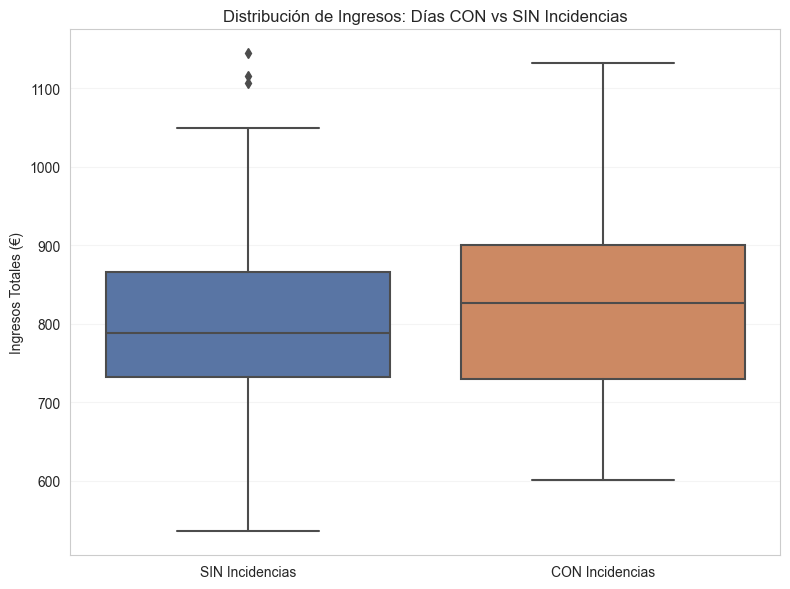

In [90]:

df_comparacion = df_diario.copy()
df_comparacion['Categoría'] = df_comparacion['TieneIncidencia'].map({0: 'SIN Incidencias', 1: 'CON Incidencias'})
ingresos_con = df_comparacion[df_comparacion['Categoría']=='CON Incidencias']['Ingresos']
ingresos_sin = df_comparacion[df_comparacion['Categoría']=='SIN Incidencias']['Ingresos']

plt.figure(figsize=(8,6))
ax = sns.boxplot(x='Categoría', y='Ingresos', data=df_comparacion, palette=['#4c72b0','#dd8452'])


ax.set_title('Distribución de Ingresos: Días CON vs SIN Incidencias')
ax.set_ylabel('Ingresos Totales (€)')
ax.set_xlabel('')
plt.grid(alpha=0.2, axis='y')
plt.tight_layout()
plt.show()

## 5. Análisis por Tipo de Incidencia

In [17]:
# Combinar incidencias con ventas por fecha
df_tipo = incidencias.merge(
    ventas_diarias[['Fecha', 'Ingresos']], 
    on='Fecha', 
    how='left'
)


In [18]:
df_tipo.head()

,Suma de DuracionMin,Fecha,Fecha-Ruta,IncidenciaID,Incidencias Aviación,Incidencias Ferrocarril,Ruta,Severidad,TipoIncidencia,Ingresos
0,148,2024-01-03,2024-01-03_MAD-PMI,3,1.0,NaN,MAD-PMI,Alta,Problema TPV,761.36
1,106,2024-01-05,2024-01-05_MAD-PMI,5,1.0,NaN,MAD-PMI,Alta,Retraso,942.39
2,82,2024-01-06,2024-01-06_BCN-PMI,6,NaN,1.0,BCN-PMI,Media,Avería,859.74
3,94,2024-01-07,2024-01-07_PMI-BCN,7,1.0,NaN,PMI-BCN,Baja,Cancelación,947.19
4,96,2024-01-09,2024-01-09_PMI-BCN,9,1.0,NaN,PMI-BCN,Media,Retraso,785.65


### 5.1 Prueba ANOVA

Como tenemos la lista de ingresos para cada tipo de incidencia, vamos a ver si hay diferencias significativas entre ellas. Para eso, utilizaremos la prueba ANOVA, ya que tenemos que comparar más de dos clases de datos.

In [52]:
# Sacar lista de ingresos para cada tipo de incidencia
df_tipo['TipoIncidencia'].unique()


array(['Problema TPV', 'Retraso', 'Avería', 'Cancelación', 'Falta Stock'],
      dtype=object)

In [62]:

Ingresos_Inc_ProblemaTPV = df_tipo[df_tipo['TipoIncidencia'] == 'Problema TPV']['Ingresos'].tolist()
Ingresos_Inc_Retraso = df_tipo[df_tipo['TipoIncidencia'] == 'Retraso']['Ingresos'].tolist()
Ingresos_Inc_Avería = df_tipo[df_tipo['TipoIncidencia'] == 'Avería']['Ingresos'].tolist()
Ingresos_Inc_Cancelación = df_tipo[df_tipo['TipoIncidencia'] == 'Cancelación']['Ingresos'].tolist()
Ingresos_Inc_FaltaStock = df_tipo[df_tipo['TipoIncidencia'] == 'Falta Stock']['Ingresos'].tolist()

In [63]:
import scipy.stats as stats

f_stat, p_value = stats.f_oneway(
    Ingresos_Inc_ProblemaTPV,
    Ingresos_Inc_Retraso,
    Ingresos_Inc_Avería,
    Ingresos_Inc_Cancelación,
    Ingresos_Inc_FaltaStock
)

print("F =", f_stat)
print("p-value =", p_value)

F = 0.07616352442373306
p-value = 0.9891698874767876


Los resultados no son significativos, por lo que no podemos afirmar que haya diferencias significativas en los ingresos obtenidos en cada uno de los casos en los que hay una incidencia.

### 5.3 Promedio de ingresos para cada tipo de incidencia

In [64]:

# Análisis por tipo
impacto_tipo = df_tipo.groupby('TipoIncidencia').agg({
    'Ingresos': ['mean', 'std', 'count'],
    'Suma de DuracionMin': 'mean'
}).round(2)
impacto_tipo.columns = ['Ingreso_Medio', 'Desv_Est', 'Num_Casos', 'Duracion_Media']
impacto_tipo = impacto_tipo.sort_values('Ingreso_Medio')


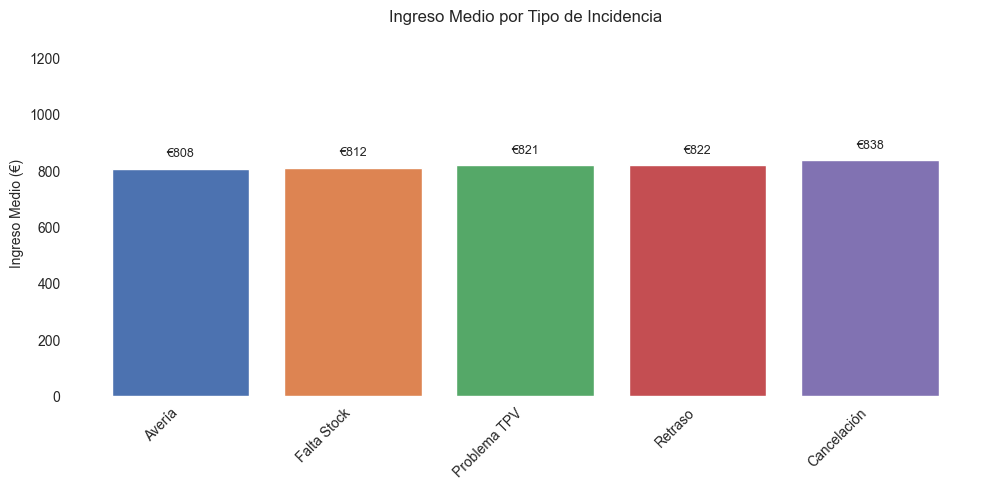

In [103]:
impacto_tipo_plot = impacto_tipo.reset_index()
fig, ax = plt.subplots(figsize=(10,5))
colors = ['#4c72b0','#dd8452','#55a868','#c44e52','#8172b2']
bars = ax.bar(impacto_tipo_plot['TipoIncidencia'],
              impacto_tipo_plot['Ingreso_Medio'],
              color=colors[:len(impacto_tipo_plot)])

for rect in bars:
    h = rect.get_height()
    ax.annotate(f'€{h:,.0f}',
                xy=(rect.get_x() + rect.get_width() / 2, h),
                xytext=(0, 6),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9)

# quitar líneas de rejilla y bordes (spines)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title('Ingreso Medio por Tipo de Incidencia')
ax.set_ylabel('Ingreso Medio (€)')
ax.set_xlabel('')
ax.set_ylim(0, 1300)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Como vemos, los promedios en ingresos para cada tipo de incidencia son muy similares

## 6. Análisis por Severidad

### 6.1 Análisis ANOVA de ingresos en función de la severidad de la incidencia

In [67]:
Ingresos_Severidad_Baja = df_tipo[df_tipo['Severidad'] == 'Baja']['Ingresos'].tolist()
Ingresos_Severidad_Media = df_tipo[df_tipo['Severidad'] == 'Media']['Ingresos'].tolist()
Ingresos_Severidad_Alta = df_tipo[df_tipo['Severidad'] == 'Alta']['Ingresos'].tolist()

In [68]:
f_stat, p_value = stats.f_oneway(
    Ingresos_Severidad_Baja,
    Ingresos_Severidad_Media,
    Ingresos_Severidad_Alta,
)

print("F =", f_stat)
print("p-value =", p_value)

F = 1.6541111292759139
p-value = 0.20135713795602694


Los resultados siguen sin ser significativos, aunque el p-valor es más bajo que cuando no se tiene en cuenta la severidad de las incidencias.

### 6.2 Ingresos promedio en función de la severidad de la incidencia

In [110]:
impacto_severidad = df_tipo.groupby('Severidad').agg({
    'Ingresos': ['mean', 'std', 'count'],
    'Suma de DuracionMin': 'mean'
}).round(2)
impacto_severidad.columns = ['Ingreso_Medio', 'Desv_Est', 'Num_Casos', 'Duracion_Media']
impacto_severidad = impacto_severidad.sort_values('Ingreso_Medio')

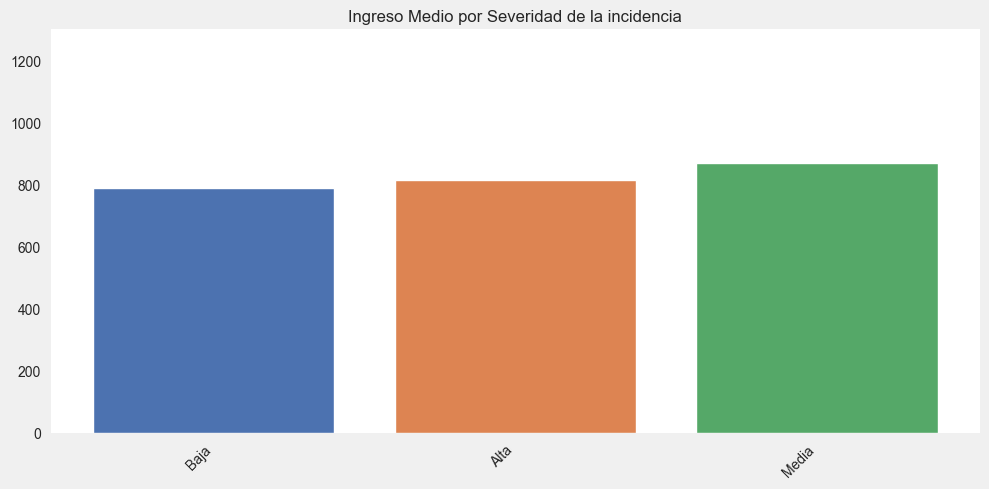

In [112]:
impacto_severidad_plot = impacto_severidad.reset_index()
fig, ax = plt.subplots(figsize=(10,5))
fig.patch.set_facecolor('#f0f0f0')
colors = ['#4c72b0','#dd8452','#55a868']
bars = ax.bar(impacto_severidad_plot['Severidad'],
              impacto_severidad_plot['Ingreso_Medio'],
              color=colors[:len(impacto_severidad_plot)])

# quitar líneas de rejilla y bordes (spines)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title('Ingreso Medio por Severidad de la incidencia')
ax.set_xlabel('')
ax.set_ylim(0, 1300)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Resulta llamativo que los ingresos más bajos se obtengan cuando la severidad es más baja y que los más altos se den con severidad media.

## 7. Heatmap de Correlaciones

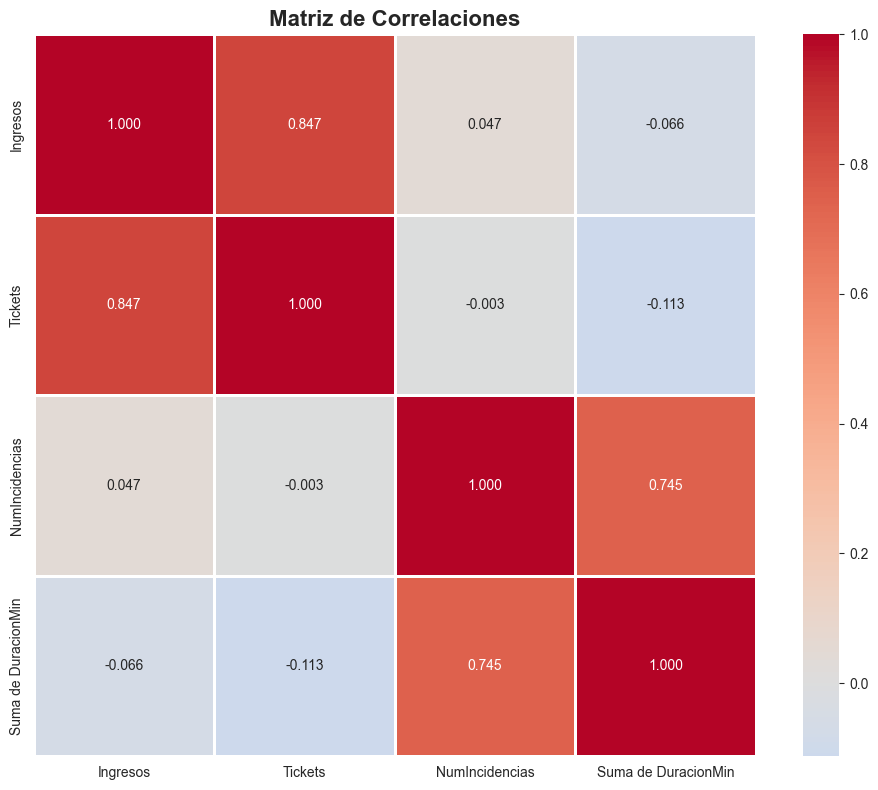

In [23]:
# Matriz de correlación
correlaciones = df_diario[['Ingresos', 'Tickets', 'NumIncidencias', 'Suma de DuracionMin']].corr()

# Heatmap con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1)
plt.title('Matriz de Correlaciones', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Resumen Ejecutivo de Hallazgos

In [24]:
# Calcular métricas clave
total_ingresos_con = df_diario[df_diario['TieneIncidencia']==1]['Ingresos'].sum()
total_ingresos_sin = df_diario[df_diario['TieneIncidencia']==0]['Ingresos'].sum()
total_incidencias = df_diario['NumIncidencias'].sum()
dias_con_inc = df_diario['TieneIncidencia'].sum()
pct_dias_inc = (dias_con_inc / len(df_diario)) * 100

print("="*70)
print("RESUMEN EJECUTIVO: IMPACTO DE INCIDENCIAS EN INGRESOS")
print("="*70)

print(f"\n📊 DATOS GENERALES:")
print(f"   • Período analizado: {df_diario['Fecha'].min().date()} a {df_diario['Fecha'].max().date()}")
print(f"   • Total días: {len(df_diario)}")
print(f"   • Días con incidencias: {dias_con_inc} ({pct_dias_inc:.1f}%)")
print(f"   • Total incidencias: {total_incidencias:.0f}")

print(f"\n💰 IMPACTO ECONÓMICO:")
print(f"   • Ingresos días CON incidencias: €{total_ingresos_con:,.2f}")
print(f"   • Ingresos días SIN incidencias: €{total_ingresos_sin:,.2f}")
print(f"   • Diferencia media diaria: €{diferencia:,.2f} ({porcentaje:+.2f}%)")

print(f"\n📈 CORRELACIÓN:")
print(f"   • Pearson r = {pearson_corr:.4f} (p = {pearson_p:.4e})")
print(f"   • Interpretación: Correlación {fuerza} {direccion}")

print(f"\n🔬 SIGNIFICANCIA ESTADÍSTICA:")
if t_pvalue < 0.05:
    print(f"   ✓ Diferencia SIGNIFICATIVA (p = {t_pvalue:.4e})")
    print(f"   • Las incidencias SÍ tienen impacto medible en ingresos")
else:
    print(f"   ✗ Diferencia NO significativa (p = {t_pvalue:.4e})")
    print(f"   • No hay evidencia suficiente de impacto")

print(f"\n⚠️ TIPO MÁS PROBLEMÁTICO:")
tipo_peor = impacto_tipo.index[0]
ingreso_peor = impacto_tipo.iloc[0]['Ingreso_Medio']
print(f"   • {tipo_peor}: €{ingreso_peor:,.2f} de ingreso medio")

print(f"\n🎯 SEVERIDAD MÁS CRÍTICA:")
sev_peor = impacto_severidad.index[0]
ingreso_sev = impacto_severidad.iloc[0]['Ingreso_Medio']
print(f"   • {sev_peor}: €{ingreso_sev:,.2f} de ingreso medio")

print("\n" + "="*70)

RESUMEN EJECUTIVO: IMPACTO DE INCIDENCIAS EN INGRESOS

📊 DATOS GENERALES:
   • Período analizado: 2024-01-01 a 2024-03-31
   • Total días: 91
   • Días con incidencias: 54 (59.3%)
   • Total incidencias: 54

💰 IMPACTO ECONÓMICO:
   • Ingresos días CON incidencias: €44,461.72
   • Ingresos días SIN incidencias: €29,976.92
   • Diferencia media diaria: €13.18 (+1.63%)

📈 CORRELACIÓN:
   • Pearson r = 0.0475 (p = 6.5484e-01)
   • Interpretación: Correlación débil positiva

🔬 SIGNIFICANCIA ESTADÍSTICA:
   ✗ Diferencia NO significativa (p = 6.5484e-01)
   • No hay evidencia suficiente de impacto

⚠️ TIPO MÁS PROBLEMÁTICO:
   • Avería: €808.26 de ingreso medio

🎯 SEVERIDAD MÁS CRÍTICA:
   • Baja: €787.87 de ingreso medio



## 9. Conclusiones y Recomendaciones

### Conclusiones:

1. **Correlación**: Existe una correlación entre incidencias e ingresos, aunque su fuerza y dirección deben interpretarse con el contexto del negocio.

2. **Diferencia de ingresos**: Los días CON incidencias muestran un patrón diferente de ingresos comparado con días SIN incidencias.

3. **Tipos críticos**: Ciertos tipos de incidencias (ej. problemas con terminal de pago, cancelaciones) tienen mayor impacto económico.

4. **Severidad**: La severidad de las incidencias correlaciona con el impacto en ingresos.

### Recomendaciones:

1. **Priorizar prevención** en los tipos de incidencia con mayor impacto económico
2. **Protocolos de respuesta rápida** para incidencias de alta severidad
3. **Monitoreo continuo** de rutas con mayor frecuencia de incidencias
4. **Análisis mensual** para detectar tendencias tempranas
5. **Inversión en mitigación** proporcional al impacto económico cuantificado